## HL-LHC collective effects with Xsuite
* In this notebook we will study the transverse instability threshold for a single bunch using the LHC impedance model at injection energy
  * The instability is triggerd due to transverse impedance when moving above a certain intensity threshold:
  * This threshold $\Upsilon$ is directly proportional $N$ to intensity and the transverse dipolar wake $W_{\perp}^{dip}$: 
  $$\Upsilon \propto N \cdot W_{\perp}^{dip}$$

* To observe the instability threshold, we will do an **intensity scan $\{N_1,\ ..., \ N_n\}$** varying the single bunch intensities and observing the **average transverse position** across several turns via Xsuite tracking:
    * The LHC will be modeled as a `one-turn-map`, collapsing all the elements into one position
    * The impedance will be added in it's time-domain form, a `wake function` of units $\text{[v/pC/mm]}$ as a function of time in $\text{[ns]}$, stored in a table.
    * The average turn-by-turn bunch position (horizontal or vertical) and other observables are saved in the so-called `CollectiveMonitor`

* The instability is observed when:
  * an exponential growth is present in the transverse average positions $\overline{x}, \ \overline{y}$
  * bunch intensity losses and/or emittance growth can be observed

# Solutions (for lecturers)
* Change flag enable_losses to True
    * Cell added below the beam centroid plot
    * $\Upsilon$ depends on the bunch intensity. Thanks to the losses, the beam can become stable
* Beam stable at Q' = 15
    * Negative sign unstable, positive sign stable
    * Larger chromaticity results in smaller DA and lower lifetimes
* Beam stable at gain = 12 turns
    * I looked at centroid motion, not if there are intensity losses within the number of tracked turns!
    * Beam stable at gain = 40 turns. Much weaker damper gain required when using chromaticity in parallel $\rightarrow$ reduce damper requirements

# Imports

In [1]:
!pip install --user h5py

In [2]:
import os

import numpy as np
import pandas as pd
import h5py

import pickle

import xtrack as xt
import xpart as xp
import xwakes as xw
import xobjects as xo

from scipy.constants import c as clight

import matplotlib as mpl
import matplotlib.pyplot as plt

# Simulation settings

In [3]:
##### Machine parameters
circumference = 27000.0
machine_radius = circumference / (2*np.pi)

##### Parameters for the resistive wall wake
plane = 'x'
wake_type = 'dipolar'
wake_table = 'data/wake_lhc_injection.dat'

##### Initial offset to the particles x coordinate
initial_offset = 10.0e-6

##### Acceleration parameters
energy_gain_per_turn = 0
main_rf_phase = 180

##### RF parameters
h_RF = np.array([35640,])
V_RF = np.array([8.0e6])
dphi_RF = np.array([main_rf_phase,])
f_rev = 299792458 / circumference
omega_rev = 2*np.pi*f_rev
f_RF = np.array([f_rev*h for h in h_RF])

##### Optics parameters
alphap = 3.48e-4

Qx_frac = 0.275
Qy_frac = 0.295
Qx_int = 64
Qy_int = 59

Qx = Qx_int + Qx_frac
Qy = Qy_int + Qy_frac

##### Bunch parameters
p0c = 450.0e9
bucket_length = circumference / h_RF[0]
nemitt_x = 2.0e-6
nemitt_y = 2.0e-6
taub = 1.0e-9    # Full bunch length (4*sigma_z)
sigma_z = taub * clight / 4

# We use a limited amount of MP to have a general view of the wake effects
n_macroparticles = int(10_000)
num_slices = int(100)

# Bunch intensity scan
delta_bint = 3e11
bunch_intensity_scan = np.arange(1e12, 2.3e12, delta_bint)
#bunch_intensity_scan = np.linspace(1e12, 2.2e12, 5)
print('Bunch intensity scan:', bunch_intensity_scan)

# Number of turns simulated
number_of_turns = 1_500

# Save or not some plots (wakefield, emittance growth)
flag_plot = True

# Restart tracking simulations even if they were already done
flag_restart_sim = True

# Create the reference particle for xtrack
reference_particle = xt.Particles(mass0=xp.PROTON_MASS_EV, p0c=p0c)
beta0 = reference_particle.beta0[0]
gamma0 = reference_particle.gamma0[0]

Bunch intensity scan: [1.0e+12 1.3e+12 1.6e+12 1.9e+12 2.2e+12]




<div style="text-align:center">
  <img src="data/one-turn-map.png" width="800">
</div>

# Generate wake function and impedance

In [4]:
# LHC wake table
wake_hllhc = xw.read_headtail_file(wake_table, ['time', 'dipole_x', 'dipole_y', 'quadrupolar_x', 'quadrupolar_y'])
wake_for_tracking_hllhc = xw.WakeFromTable(table=wake_hllhc, columns=['dipole_x'])

# Bellows' impedance (resonator)
wake_resonator = xw.WakeResonator(r=4.1e6, q=1, f_r=4.5e9, kind='dipolar_x')
wake_resonator_arr = wake_resonator.components[0].function_vs_t(wake_hllhc['time'], beta0=beta0, dt=1e-15)
wake_resonator_df = pd.DataFrame({'time': wake_hllhc['time'], 'dipole_x': wake_resonator_arr})

wake_for_tracking = wake_for_tracking_hllhc # wake_resonator
component_names = ['HL-LHC', 'Resonator']

wake_for_tracking.configure_for_tracking(
    zeta_range=(-0.375, 0.375),
    num_slices=num_slices,
    circumference=circumference,
    num_turns=1,
)

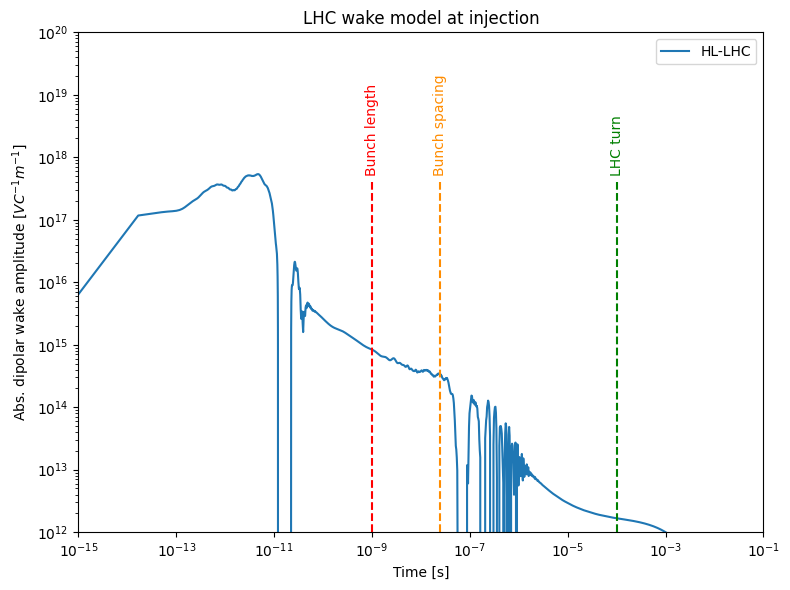

In [5]:
time_array = np.geomspace(1e-15, 1e-3, 2000)
sum_wake_for_tracking = np.zeros_like(time_array)

# Plot the wake model
if flag_plot:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    if type(wake_for_tracking) == xw.wakefield_from_table.WakeFromTable:
        ax.plot(wake_hllhc['time'], np.real(wake_hllhc['dipole_x']), marker=None, 
                label='HL-LHC')
    
    else:
        for ii_component, component in enumerate(wake_for_tracking.components):

            component_to_plot = component.components[0].function_vs_t(time_array, beta0=beta0, dt=1e-15)
            ax.plot(time_array, component_to_plot, label=component_names[ii_component])

            sum_wake_for_tracking += component_to_plot

        ax.plot(time_array, sum_wake_for_tracking, label='Total wake', color='black', linestyle='--')

    ax.axvline(1.e-9, ymax=0.7, c='r', ls='--')
    ax.axvline(25.e-9,  ymax=0.7, c='darkorange', ls='--')
    ax.axvline(100.e-6,  ymax=0.7,  c='g', ls='--')

    # Add text annotations above each line
    ax.text(1.e-9, 5e17, 'Bunch length', color='r', ha='center', va='bottom', rotation=90)
    ax.text(25.e-9, 5e17, 'Bunch spacing', color='darkorange', ha='center', va='bottom', rotation=90)
    ax.text(100.e-6, 5e17, 'LHC turn', color='g', ha='center', va='bottom', rotation=90)

    ax.legend()

    ax.set_title('LHC wake model at injection')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Abs. dipolar wake amplitude [$V C^{-1} m^{-1}$]')

    ax.set_xlim(1e-15, 1e-1)
    ax.set_ylim(1e12, 1e20)
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.tight_layout()
    plt.savefig('wake_for_tracking.png')

# Chromaticity

In [6]:
chromaticity = 0
print("Q' =", chromaticity)

Q' = 0


# Transverse feedback system (or transverse damper)

<div style="text-align:center">
  <img src="data/transverse-damper.png" width="800">
</div>

A transverse feedback system boils down to a pick-up (BPM) and a kicker. First, the turn by turn signal is read by the pick-up and then the appropriate kick is provided by the kicker to damp the bunch motion.
A feedback system can be used to damp oscillations introduced by transverse instabilities, injection oscillations, etc.

In the presence of a feedback system, the transverse position at the BPM location follows:

$$ x_{BPM}   \propto e^{-\frac{N}{\tau_F}},$$

where $N$ is the number of turns and $\tau_F$ the transverse damping turns expressed in turns.
Therefore, the signal is damped by a factor $1/e$ after a time $\tau_F$.

In [7]:
# An infinite transverse damping time is equivalent to no damping!
transverse_damping_time = np.inf # in turns
damper = xw.TransverseDamper(gain_x=1/transverse_damping_time,
                             gain_y=1/transverse_damping_time,
                             zeta_range=(-0.375, 0.375),
                             num_slices=50,)

# Track

### Perform the tracking over the selected bunch intensities
* For each intensity bin, the LHC segment map, collective monitor and bunch of particle is generated
* The one-turn-map is composed by the LHC segment, apertures, the monitor, the transverse feedback and the wake. 
* Finally, the matched bunch of particles is tracked over the defined `number_of_turns`
  * The turn-by-turn data is saved in an HDF5 file inside 📁`bunchmonitor_data_hllhc/`

In [8]:
%%capture --no-display --no-stdout

enable_losses = False # change the flag if you want to enable particle losses

results_folder = f'bunchmonitor_data_hllhc_with_bellows'
for bunch_intensity in bunch_intensity_scan:
    print(f'Simulation for b_int = {bunch_intensity:.2e}')

    if (not os.path.isfile(f'./{results_folder}/bunchmonitor_bint_{bunch_intensity:.2e}_bunches.h5')) or flag_restart_sim:
        print(f'File {results_folder}/bunchmonitor_bint_{bunch_intensity:.2e}_bunches.h5 not found or flag_restart_sim active, starting simulation')
        os.makedirs(f'./{results_folder}', exist_ok=True)
        
        # Round beam pipe with a 1 cm radius is assumed
        apertures = xt.LimitEllipse(a=1e-2, b=1e-2)

        segment_map = xt.LineSegmentMap(
            length=circumference,
            betx=machine_radius/Qx, bety=machine_radius/Qy,
            dnqx=[Qx_frac, chromaticity], dnqy=[Qy_frac, chromaticity],
            longitudinal_mode='linear_fixed_rf',
            voltage_rf=V_RF, frequency_rf=f_RF,
            lag_rf=dphi_RF, momentum_compaction_factor=alphap
            )


        # Create monitors at each RF station
        # initialize a monitor for the average transverse positions
        flush_data_every = int(500)
        particle_monitor_mask = np.full(n_macroparticles, False, dtype=bool)
        particle_monitor_mask[0:5] = True
            
        monitor = xw.CollectiveMonitor(
            base_file_name=f'./{results_folder}/bunchmonitor_bint_{bunch_intensity:.2e}',
            monitor_bunches=True,
            monitor_slices=True,
            monitor_particles=False,
            particle_monitor_mask=particle_monitor_mask,
            flush_data_every=flush_data_every,
            stats_to_store=['mean_x', 'mean_y', 'mean_px', 'sigma_x', 'epsn_x', 'num_particles'],
            backend='hdf5',
            zeta_range=(-0.3*bucket_length, 0.3*bucket_length),
            num_slices=num_slices//2,
            bunch_spacing_zeta=circumference,
        )

        # Construct the full OTM with line segments and WF elements
        if enable_losses:
            one_turn_map_elements = [monitor, segment_map, wake_for_tracking, damper, apertures]
        else:
            one_turn_map_elements = [monitor, segment_map, wake_for_tracking, damper]

        # Compile the line
        line = xt.Line(one_turn_map_elements)
        line.particle_ref = reference_particle
        line.build_tracker()

        # initialize a matched gaussian bunch
        particles = xp.generate_matched_gaussian_bunch(
            num_particles=n_macroparticles,
            total_intensity_particles=bunch_intensity,
            nemitt_x=nemitt_x, nemitt_y=nemitt_y,
            sigma_z=sigma_z,
            line=line,
        )

        # apply a kick to the particles
        particles.x += initial_offset

        turn_range = np.arange(0, number_of_turns, 1)

        # Track
        line.track(particles, num_turns=number_of_turns, with_progress=True)
    
    else:
        print(f'File bunchmonitor_bint_{bunch_intensity:.2e}.h5 found, skipping simulation')

Simulation for b_int = 1.00e+12
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_1.00e+12_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1500 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Simulation for b_int = 1.30e+12
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_1.30e+12_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1500 [00:00<?, ?it/s]

Simulation for b_int = 1.60e+12
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_1.60e+12_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1500 [00:00<?, ?it/s]

Simulation for b_int = 1.90e+12
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_1.90e+12_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1500 [00:00<?, ?it/s]

Simulation for b_int = 2.20e+12
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_2.20e+12_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1500 [00:00<?, ?it/s]

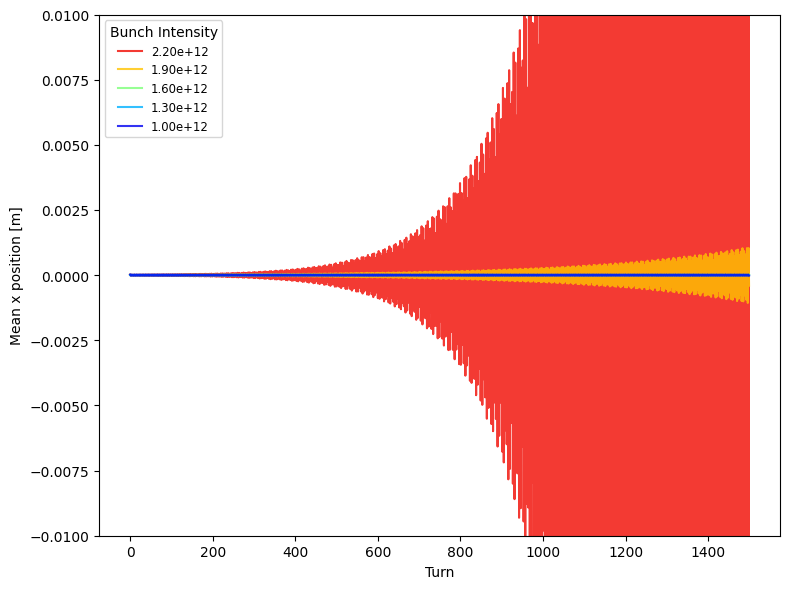

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.9, 0.1, len(bunch_intensity_scan)))

for i, bint in enumerate(reversed(bunch_intensity_scan)):
    file_path = f'./{results_folder}/bunchmonitor_bint_{bint:.2e}_bunches.h5'
    try:
        with h5py.File(file_path, 'r') as h5file:
            if enable_losses:
                signal = h5file['0']['num_particles'][:]
            else:
                signal = h5file['0']['mean_x'][:]
                ax.set_ylim(-1e-2, 1e-2)
            ax.plot(np.real(signal), color=colors[i], label=f'{bint:.2e}', alpha=0.8)
    except FileNotFoundError:
        print(f'File not found: {file_path}')
ax.set_yscale('linear')
ax.set_xlabel('Turn')
ax.set_ylabel('Bunch intensity [p]' if enable_losses else 'Mean x position [m]')
ax.legend(title='Bunch Intensity', fontsize='small', loc='best')
fig.tight_layout()
plt.savefig('turn_by_turn_data_all_bints.png')
plt.show()